# Chapter 2: Before we begin: the mathematical building blocks of neural networks

- Hello World!
    - Basic NN keras program blocks
- Data representation for DL:
    - Tensors: Rank vs. Dimension        
    - Tensors ranks: Scalar (0D), Vector (1D), Matrix (2D), TimeSeries (3D), Image (4D), Video (5D)
    - Data notations: Batches, Vector, Image, Time, Video
- Basic tensor operations
    - Digression: Tensor operations, Broadcasting, Reshape vs. Transpose
- Gradient-based optimization
    - Training loop
    - Stochastic Gradient Descent (SGD)
    - Backpropagation
- NN Anatomy:
    - Data
    - Model
    - Loss
    - Optimizer
    


## Four ingredients of Supervised learning framework:
![03_1_Anatomy_NN.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/03_1_Anatomy_NN.png?raw=true)



- Data --> $X$ and $y$

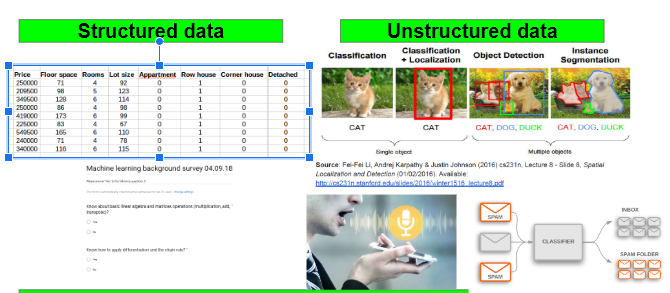
- Model --> hypothesis $\hat{y} = h(X)$ input-output relationship
- Loss/Objective/Cost --> $J(\theta) = f(y,\hat{y})$. For MSE, $J(\theta) = \frac{1}{2m} \sum_{i=0}^{m} (y_i - \hat{y}_i)^2$
- Optimizer --> Algorithm to solve/find optimal set of model parameters $\theta^*$

$$\theta^* = argmin_{\theta} J(\theta)$$



## A first look at a neural network

We will now take a look at a first concrete example of a neural network, which makes use of the Python library Keras to learn to classify 
hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this 
first example right away. You probably haven't even installed Keras yet. Don't worry, that is perfectly fine. In the next chapter, we will 
review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! 
We've got to start somewhere.

Training a neural network revolves around the following
objects:
- Layers, which are combined into a network (or model)
- The input data and corresponding targets
- The loss function, which defines the feedback signal used for learning
- The optimizer, which determines how learning proceeds



### Data

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been 
around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test 
images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST 
as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine 
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [ ]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_val, y_val) = train_test_split(train_images,train_labels,test_size=0.2,shuffle=True)

In [ ]:
train_labels[100] = 10

`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the 
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train_labels)

60000

In [ ]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
len(test_labels)

10000

In [ ]:
test_labels.shape

(10000,)

In [ ]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [ ]:
train_images.shape

(60000, 784)

We also need to categorically encode the labels, a step which we explain in chapter 3:

In [ ]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
train_labels.shape

(60000, 10)

Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

Let's build our network -- again, remember that you aren't supposed to understand everything about this example just yet.

### Model

In [ ]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', name='Layer_1', input_shape=(28 * 28,)))

network.add(layers.Dense(10, activation='softmax'))

Using TensorFlow backend.


In [ ]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


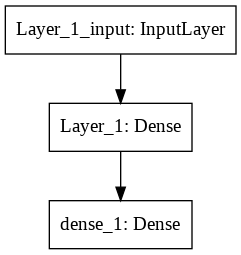

In [ ]:
from keras.utils import plot_model
plot_model(network)


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

### Compilation: loss + optimizer

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next two chapters.

In [ ]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## Loss function (objective function)
__The quantity that will be minimized during training. It represents a measure of success for the task at hand__

### Choosing the right objective function for the right problem is extremely important

your network will take any shortcut it can, to minimize the loss; so if the objective
doesn’t fully correlate with success for the task at hand, your network will end up
doing things you may not have wanted. Imagine a stupid, omnipotent AI trained via
SGD, with this poorly chosen objective function: “maximizing the average well-being
of all humans alive.” To make its job easier, this AI might choose to kill all humans
except a few and focus on the well-being of the remaining ones—because average
well-being isn’t affected by how many humans are left. That might not be what you
intended! Just remember that all neural networks you build will be just as ruthless in
lowering their loss function—so choose the objective wisely, or you’ll have to face
unintended side effects.

### Common loss functions
- __binary crossentropy__ for a _two-class_ classification problem, 
- __categorical crossentropy__ for a _many-class_ classification problem,
- __mean squared error__ for a _regression problem_
- _connectionist temporal classification (__CTC__)_ for a _sequence-learning problem_

_Only when you’re working on truly new research problems will you have to develop your own objective functions_

![04_7_last_layer_activation_and_loss.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/04_7_last_layer_activation_and_loss.png?raw=true)


# We need the activation functions in the last layer to act as decision layer:

# Regression

The output can be anything.

This means linear activation.

If the output is only positive (say price), then we use relu:

![relu](https://qph.fs.quoracdn.net/main-qimg-d23ac99265ab19599e71c9d1a3cb089a)

The loss in this case is a simple MSE:

![mse](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS61PPjY7GFxPGdKiyW81wytQjWC758tQKvpYbZH-3SnM1RF6QG)

In case of 1 neuron, this is called __linear regression__

![single_neuron](https://miro.medium.com/max/913/1*rptqFUQTMiruWZWKm-WMqQ.png)

# Binary classification (logistic regression)

Output is either zero or 1
![Sigmoid](https://miro.medium.com/max/1307/1*Be3Bhz0BA-NgZIYqRVZtug.gif)

The number we get is an output of sigmoid or _logistic_ unit. That's why this model is sometimes referred to as __logistic regression__ if it's only 1 neuron. It still classification.

The output now is a __probability__ of having the 1 class. The probability of the 0 class is 1-p.

We still need a __Threshold__. Since these are probabilities, it's safe to put the threshold at 0.5:

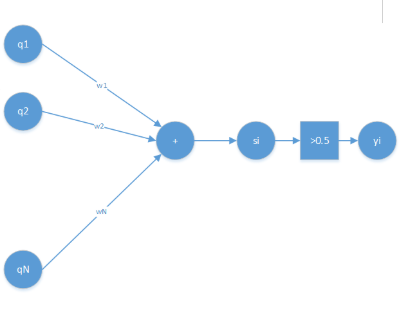

# Multi-label classification

![Multi-label](https://miro.medium.com/max/3616/1*s6Tm6f3cPhHEFdEjuCMMKQ.jpeg)

More than 1 is possible in the output

# Multi-classification

In this case, one output only is true and the rest are not. In more precise terms, we want to have probabilities output from the network, and we pick the class with highest probability.

To get those probabilities, we can normalized the outputs. We call those __normalized scores__ $f(s)_i$, which are actual probabilities

Ideally, only 1 neuron is required to be 1 and the rest are zeros. We call those targets $t_i$.

Where $0 \leq i < K$, where K is the number of classes, or sometimes called C also.

To achieve our desired output, since we take the max anyway, so we focus on the desired class neuron, __this is the probability we want maximum__. All others will depend on it then. This maximization framework is called __Cross Entropy__. 


To encode that mathematically, we do the following:

$$CE = \sum_i^K{f(s)_i^{t_i}}$$

For mathematical reasons (mainly to be able to take the gradients easier as we will see later), we take the log (note that: max the log = max the original cost):

$$CE = \sum_i^K{t_i \times log f(s)_i}$$

Normally we want to maximize that cost. But since we call it __loss__ then we want to minimize a quantity, so we take __-CE__



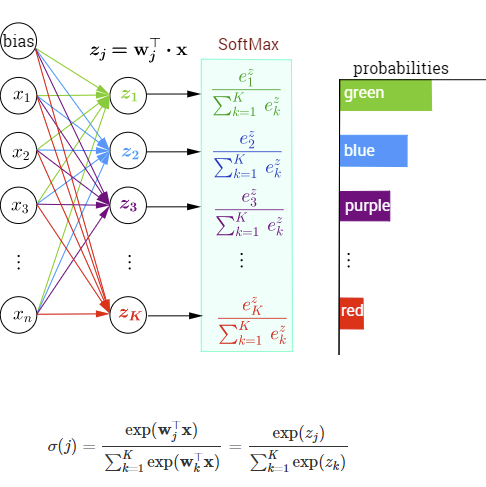

# ![BCE](https://gombru.github.io/assets/cross_entropy_loss/intro.png)

![CE](https://ztlevi.github.io/Gitbook_Machine_Learning_Questions/assets/softmax_CE_pipeline.png)

In the 2 figures above, we are usually interested in the scores $s_i$, which are the outputs at the class neurons. As you can see $log(f(s_i))$ is just $s_i$ if we neglect the denominator (common among all classes).
For this reasons $s_i$ are called _logits_. Also they represent __unnormalized probablities__, while the actual probabilitis are $f(s_i)$
In the fwd path, we just take the $argmax(s_i)$ for all class neurons.



### Learning

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

In [ ]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.2563 - acc: 0.9257
Epoch 2/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.1030 - acc: 0.9695
Epoch 3/5
60000/60000 [==============================] - 5s 76us/step - loss: 0.0698 - acc: 0.9785
Epoch 4/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0496 - acc: 0.9851
Epoch 5/5
60000/60000 [==============================] - 5s 76us/step - loss: 0.0374 - acc: 0.9891


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 47us/step


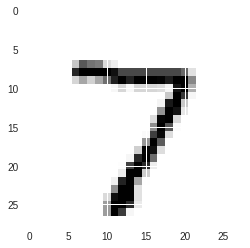

In [ ]:
import matplotlib.pyplot as plt
img = test_images[0]
plt.imshow(np.reshape(img, (28,28)))


In [ ]:
img.shape

(784,)

In [ ]:
network.predict(np.reshape(img, (1,784)))

array([[0.07699326, 0.07023557, 0.09060565, 0.1736434 , 0.07890654,
        0.09350489, 0.08068074, 0.09926819, 0.09897252, 0.13718927]],
      dtype=float32)

In [ ]:
np.argmax(network.predict(np.reshape(img, (1,784))))

3

In [ ]:
print('test_acc:', test_acc)

test_acc: 0.9794



Our test set accuracy turns out to be 97.8% -- that's quite a bit lower than the training set accuracy. 
This gap between training accuracy and test accuracy is an example of "overfitting", 
the fact that machine learning models tend to perform worse on new data than on their training data. 
Overfitting will be a central topic in chapter 3.

This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in 
less than 20 lines of Python code. In the next chapter, we will go in detail over every moving piece we just previewed, and clarify what is really 
going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which 
layers are made of, and about gradient descent, which allows our network to learn from its training examples.

# Model choice

- Model --> hypothesis $\hat{y} = h(X)$, what is $h$?
  - __Deterministic__ You know the relation (from mathematical modeling of physical phenomenon)
  - __Statistical learning__
    - Non parametric: K-NN--> For every new point, look the surrounding K-points and assign the majority label to $\hat{y}$. This is both slow and memory consuming during inference.
    - Parametric $\hat{y} = h(X;\theta))=h_{\theta}(X)$, read as mapping function (model) of input $X$ to output $y$, parametrized by $\theta$

# Overfitting

As we increase the number of features, and add more non-linearity (more layers), we get a better curve that fits the data.


![overfitting](https://media.geeksforgeeks.org/wp-content/cdn-uploads/20190523171229/overfitting_1.png)

![overfitting_cls](https://media.geeksforgeeks.org/wp-content/cdn-uploads/20190523171258/overfitting_2.png)

However, this is for the data we have adjusted the weights for: __training data__

What about unseen data? __test data__

We might have a new sample that lies on the other side of the boundary that we did not see during training.

For that, we might accept some error on training data, so that we have __Generalized__ model on test data as well.

On the other hand, if we can't achieve accepted performance on the trainig data, we call this __underfitting__


We control overfitting and underfitting by __model compexity__, also called __model capacity__. Usually the increased number of model parameters (for parametric models), means more model complexity:

- More layers
- More features (means more weights)
- Overtraing: handled by __early stopping__
- Higher magnitude of weights. This can be avoided by putting penalty on the magitude in the loss, called __regularization__

# Optimizer: How to find the weights or parameters?
https://colab.research.google.com/drive/1IOtIEE9-V4mfViKF9yt602ROPesjX3uT?authuser=1

- Option 1: __Closed form solution__ Let's solve the equations!

- Option 2: __Search__! try all possible values of w's and choose the set with min loss --> __Numerical solution = optmization__



- Option 2.1: __Random search__ same as search, but choose random subset of all possible w's

- Option 2.2: __Guided search__ start from random w's, measure the loss, then choose the next set of w's _guided by_ the change in the loss.

__How to use the loss change as a guidance?__

## Normal Equation:
https://docs.google.com/presentation/d/1hAit5xIHZw1Fs3Hi2mglkHRIidgKB8G4qRj8NzUHcO4/edit#slide=id.g75a34bdec9_0_215

See: https://docs.google.com/presentation/d/0B66YEDFW_5Xzdmw3VkNVVDl0S0E/edit#slide=id.p87 "Function approximation with a Neuron" part

We have N-points (X,y), and we want to min the MSE. Derive and equal =0 --> solve for $\theta$


$\theta^{*} = (X^T.X)^{-1} . X . y$

Code:
https://colab.research.google.com/drive/1IOtIEE9-V4mfViKF9yt602ROPesjX3uT?authuser=1#scrollTo=ZnvIqyl_9F96

Disadv:

- Slow (X is a big matrix, inverse is costly and not always existing)
- Uses all the data points --> Might overfit (more on that later)
- It doesnt work for classification. Only regression, since some equations will vanish and we'll have infinite solutions (infinite lines can separate the classes with 0 MSE)



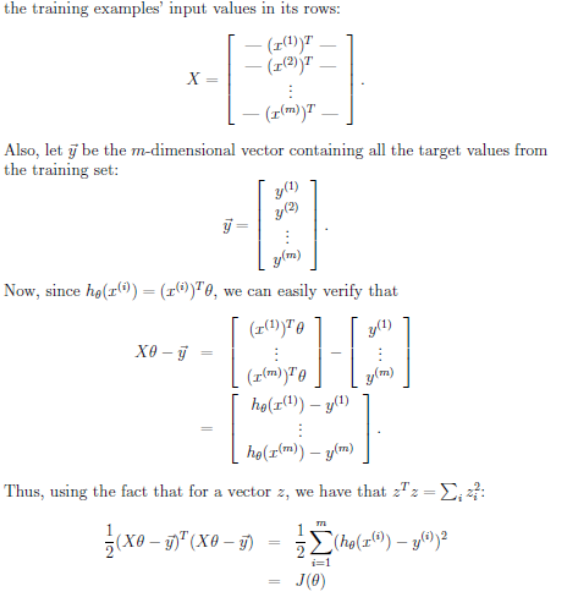

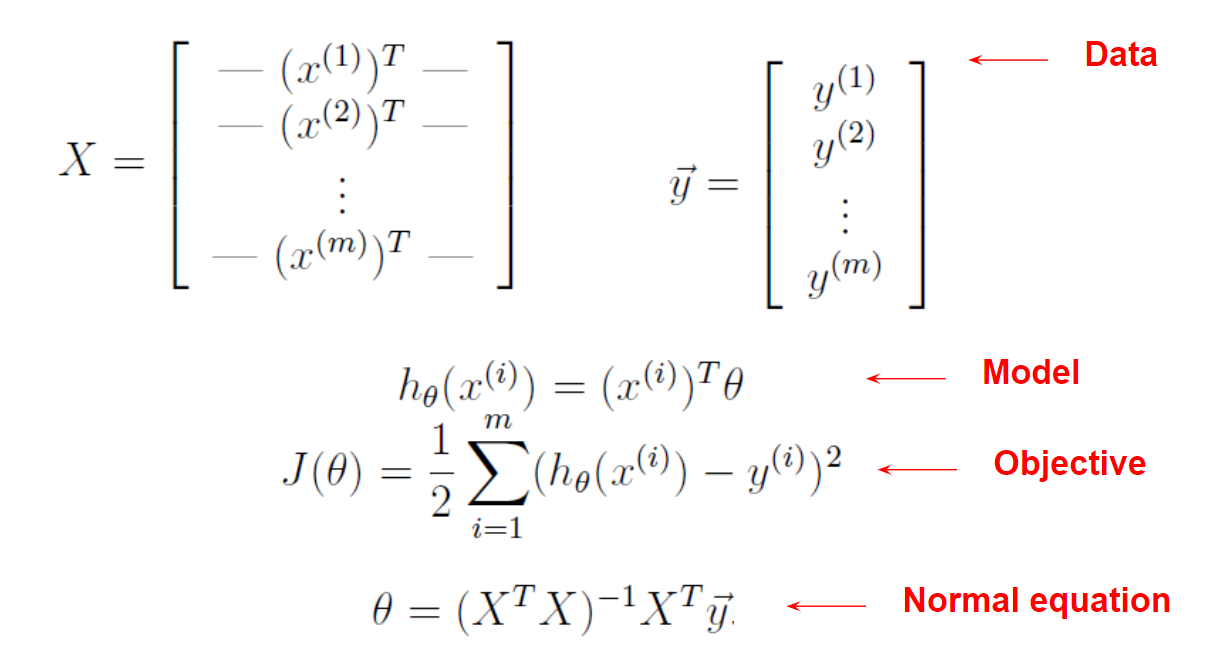

__Proof__
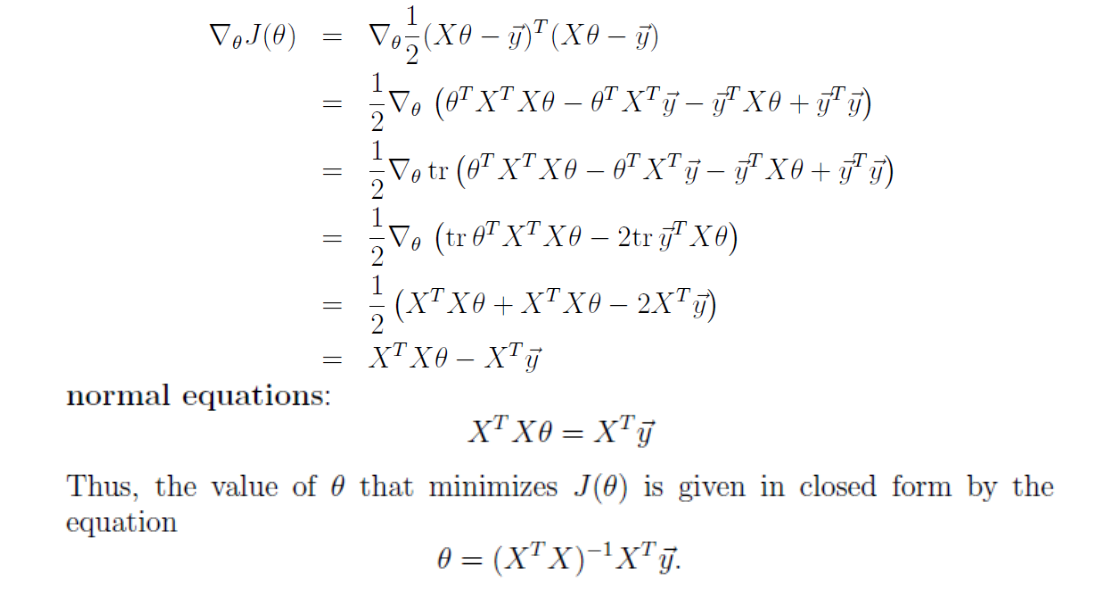

# Search (Guided search)

## Gradient based optimization


What we want to have at the end from a NN is a `Model`, represents an input-output relation
![02_gd.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/02_gd.png?raw=true)

# What is a gradient?
Analytic vs. Numerical gradient
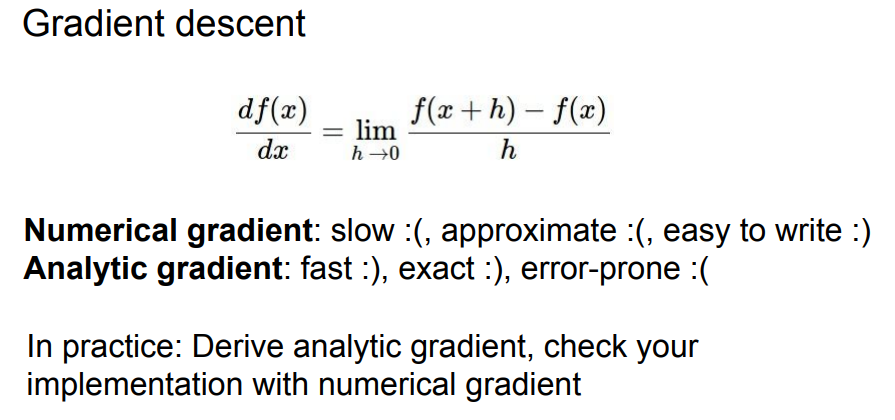




## Sensitivity

A gradient is $\frac{\delta{y}}{\delta{x}}$, meaning how much y changes when we change x by small amount. In other words, it's the rate of change of y with x.

![sensitivty](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQrbjrQgxAQGH6ZAHfG2Kfv-3wtn67urmCvHT6BilKT9eKlYxFD)

In case of loss, the gradient $\frac{\delta{loss}}{\delta{w}}$ is how much the loss changes when we change a weight with small amount. It guides our search of the the weights that minimizes the loss; if we change w a bit, and the loss is affected a lot, it means that the loss is sensitive to this change.

In case of MSE loss for example, since the loss is always convex, it means any change in w moves the loss away from the miniumum. So if we move against it, we reach the minimum. If this change value is small, it means we need to move a small step (we are alreay at the min: $\frac{\delta{loss}}{\delta{w}=0}$), and vice versa.



## Weight loss for single neuron

Now if we have one layer of neurons/features, we can easily know the sensitivity of the loss to the connecting weight of each $\frac{\delta{loss}}{\delta{w_i}}$, where $w_i$ is the connecting weight of neuron/feature i to the output.

![single_neuron](https://miro.medium.com/max/913/1*rptqFUQTMiruWZWKm-WMqQ.png)



output = relu(dot(W, input) + b)

The model has `parameters` in the above case those are `W` and `b`.
They’re called the weights or trainable parameters of the layer (the kernel and bias attributes, respectively).
These weights contain the information learned by the network from exposure to training data.

Initially, these weight matrices are filled with small random values (a step called random
initialization). Of course, there’s no reason to expect that relu(dot(W, input) + b),
when W and b are random, will yield any useful representations. The resulting representations
are meaningless—but they’re a starting point. 
### Learning:
What comes next is to gradually
adjust these weights, based on a feedback signal. This gradual adjustment, also called
training, is basically the learning that machine learning is all about.

## Training loop

This happens within what’s called a training loop, which works as follows. Repeat
these steps in a loop, as long as necessary:

1. Draw a batch of training samples x and corresponding targets y.
2. Run the network on x (a step called the forward pass) to obtain predictions y_pred.
3. Compute the loss of the network on the batch, a measure of the mismatch between y_pred and y.
4. Update all weights of the network in a way that slightly reduces the loss on this batch.

You’ll eventually end up with a network that has a very low loss on its training data: a
low mismatch between predictions y_pred and expected targets y. The network has
“learned” to map its inputs to correct targets. From afar, it may look like magic, but
when you reduce it to elementary steps, it turns out to be simple.

Step 1 sounds easy enough—just I/O code. Steps 2 and 3 are merely the application
of a handful of tensor operations, so you could implement these steps purely
from what you learned in the previous section. The difficult part is step 4: updating
the network’s weights. 
### Given an individual weight coefficient in the network, how can you compute whether the coefficient should be increased or decreased, and by how much?
One naive solution would be to freeze all weights in the network except the one
scalar coefficient being considered, and try different values for this coefficient. Let’s
say the initial value of the coefficient is 0.3. After the forward pass on a batch of data,
the loss of the network on the batch is 0.5. If you change the coefficient’s value to 0.35
and rerun the forward pass, the loss increases to 0.6. But if you lower the coefficient to
0.25, the loss falls to 0.4. In this case, it seems that updating the coefficient by -0.05 would contribute to minimizing the loss. This would have to be repeated for all coefficients
in the network. But such an approach would be horribly inefficient, because you’d need to compute
two forward passes (which are expensive) for every individual coefficient (of
which there are many, usually thousands and sometimes up to millions).


## Follow the opposite gradient down: Gradient Descent
 A much better
approach is to take advantage of the fact that all operations used in the network
are differentiable, and compute the gradient of the loss with regard to the network’s
coefficients. You can then move the coefficients in the opposite direction from the
gradient, thus decreasing the loss.

![image.png](attachment:image.png)

```
y_pred = dot(W, x)
loss_value = loss(y_pred, y) # loss_value = f(W)
# Let’s say the current value of W is W0.
# Update weights opposite to the gradient of the loss at the W=W0
W1 = W0 - step * gradient(f)(W0)# gradient(f) w.r.t. W is easily calculated in DL frameworks thanks to sybmolic auto diff.
# Repeat for W2, W3,....W100
```

# Different options of the training loop:
https://colab.research.google.com/drive/11_-SxhdtxvRYdPukURz-cojd7-JdpiKR?authuser=1

## Stochastic Gradient Descent
### GD (batch SGD)
The above GD algorithm updates the gradient with every new sample of x.
If X is of 1000 samples, then the delta_W[t+1] = step * gradient(f)(W[t]) is calculated and accumulated every sample, but the application of weight update is done once after all 1000 samples are fed.

- Update once at the end
- High accumulation of error, Risk of saturation
- Slow feedback, slow convergence, but more stable
- Take advantage of parallelism in matrix operations (comp. arch.)

### SGD
There are other options of updating:
1. SGD: Each sample (batch_size=1)

    - Fast feedback, fast convergence (corrects itself a lot) 
    - Could oscillate, unstable (tend to corrupt what it learnt)
    - Not taking advantage of parallelism in matrix operations (comp. arch.)
    - Not saturating
    - Stochastic: every update is a representing sample of the true gradient 
2. Minibatch SGD: Every group of samples (batch_size=N)
Accumulate M gradients, update every M
    - More stable than 1 sample
    - Faster than GD
### Steps
    1. Draw a batch of training samples x and corresponding targets y.
    2. Run the network on x to obtain predictions y_pred.
    3. Compute the loss of the network on the batch, a measure of the mismatch
    between y_pred and y.
    4. Compute the gradient of the loss with regard to the network’s parameters (a
    backward pass).
    5. Move the parameters a little in the opposite direction from the gradient—for
    example W -= step * gradient—thus reducing the loss on the batch a bit.

### Learning rate
As you can see, intuitively it’s important to pick a reasonable value for the step factor.
If it’s too small, the descent down the curve will take many iterations, and it could get
stuck in a local minimum. If step is too large, your updates may end up taking you to
completely random locations on the curve.

### Momentum
Additionally, there exist multiple variants of SGD that differ by taking into account
previous weight updates when computing the next weight update, rather than just
looking at the current value of the gradients. There is, for instance, SGD with momentum,
as well as Adagrad, RMSProp, and several others. Such variants are known as optimization
methods or optimizers. In particular, the concept of momentum, which is used in
many of these variants, deserves your attention. Momentum addresses two issues with
SGD: convergence speed and local minima.
    
Momentum draws inspiration from physics.
A useful mental image here is to think of the optimization process as a small ball
rolling down the loss curve. If it has enough momentum, the ball won’t get stuck in a
ravine and will end up at the global minimum. Momentum is implemented by moving
the ball at each step based not only on the current slope value (current acceleration)
but also on the current velocity (resulting from past acceleration). In practice, this
means updating the parameter w based not only on the current gradient value but also
on the previous parameter update, such as in this naive implementation:

```
past_velocity = 0.
momentum = 0.1
while loss > 0.01:
    w, loss, gradient = get_current_parameters()
    velocity = past_velocity * momentum + learning_rate * gradient
    w = w + momentum * velocity - learning_rate * gradient
    past_velocity = velocity
    update_parameter(w)
```    

### Momentum to avoid local min


![02_momentum.png](https://github.com/ahmadelsallab/practical_dl/blob/master/Keras/notebooks/imgs/02_momentum.png?raw=true)

You can avoid such issues by using momentum, 

# How to measure overfitting?

By monitoring the train and test error. Very common technique is __early stopping__: use the model parameters just before the overfitting point.
![tain_test_err](https://www.researchgate.net/profile/Jaroslav_Bendl/post/Overfitting_or_not/attachment/59d64cf879197b80779a6a0a/AS%3A486315180466177%401492957982628/download/overfitting.png)

# Bias and Variance
The error of prediction is composed of two main contributions, the remaining interference error and the estimation error [39]. 

1- The interference error is the systematic error __(bias)__ due to unmodeled interference in the data, as the calibration model is not complex enough to capture all the interferences of the relationship between sensor responses and analytes. __training data modeling__ 

_High bias means underfitting_

2- The estimation error is caused by modeling measured random noise of various kinds. In other words, the __variance__ between the training and testing data (variance is a measure of noise, or how much variability is there between the training (mean) data and testing data).


_High variance means overfitting_

The optimal prediction is obtained, when the remaining interference error and the estimation error balance each other. 

[src](http://www.frank-dieterle.de/phd/2_8_1.html)

![model_complexity](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR4oHkgXwLkyYnTTWfVrXDZm77zETws4LThdvkRNW7r4BvnB5sQ)

# Regularization 


Most common is L1 and L2 (abs or norm (square) of the weights)

![Regularization](https://miro.medium.com/max/1346/1*HP4RnnX-S3qyb4qrmI0MVQ.png)

__Ridge Regression __

L2

https://colab.research.google.com/drive/1IOtIEE9-V4mfViKF9yt602ROPesjX3uT?authuser=1

__Lasso Regression__

L1

https://colab.research.google.com/drive/1IOtIEE9-V4mfViKF9yt602ROPesjX3uT?authuser=1


# Going deaper: why?

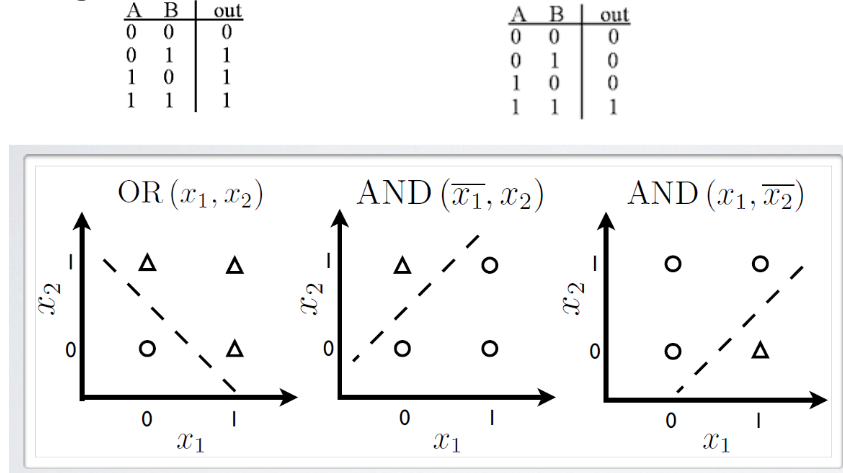

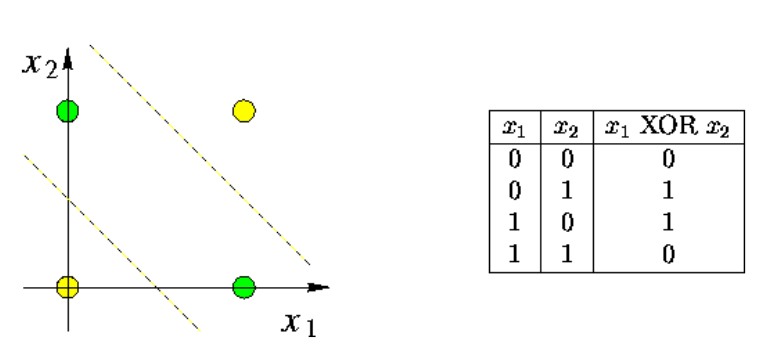

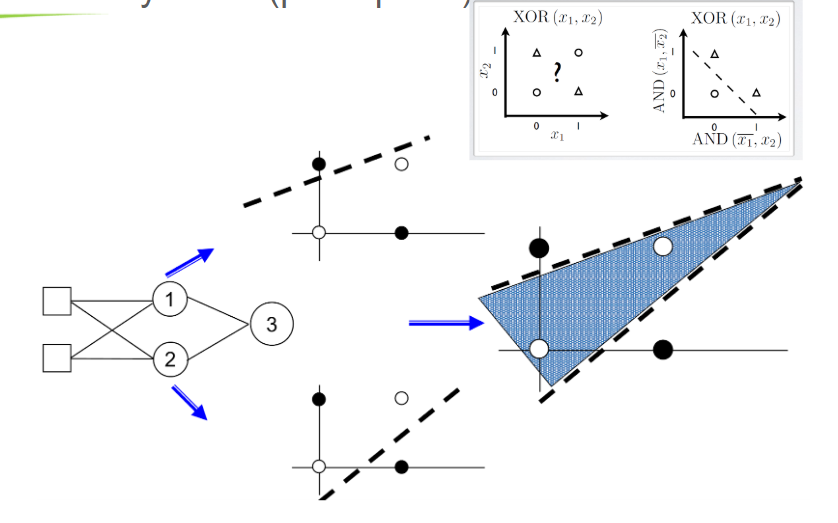

# Why we need activation functions?

As we have see above, one neuron creates one line (or plane in n-D).

For one layer of neurons, we need activation functions to _decide_ on the output.

But why we need them in the intermediate neurons?

As we saw in the XOR example, we needed 2 lines. However, if they are just 2 lines, without any decision actions on their outputs, we are still having one linear mapping!

$$y = w_{31}(w_{11}x_1+w_{12}x_2) + w_{32}(w_{21}x_1+w_{22}x_2)$$

So we still have one line. But this is not what we wanted! 
We wanted __three__ mapped points in a __new space__

To achieve this mapping, we need an activation function, say sign or sigmoid.

Similarly, if the best boundary we want is __non linear__, we need different activation functions to achieve this non linearity:

![non linear](https://www.researchgate.net/profile/Joshua_Balsters/publication/311249567/figure/fig1/AS:434500946665472@1480604506191/Linear-versus-non-linear-classification-Illustration-of-the-separation-of-data-samples.png)

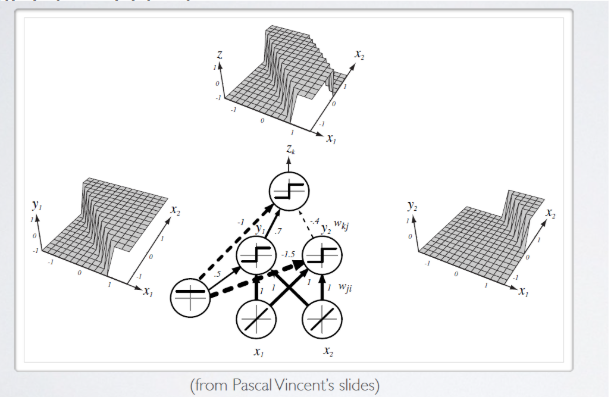

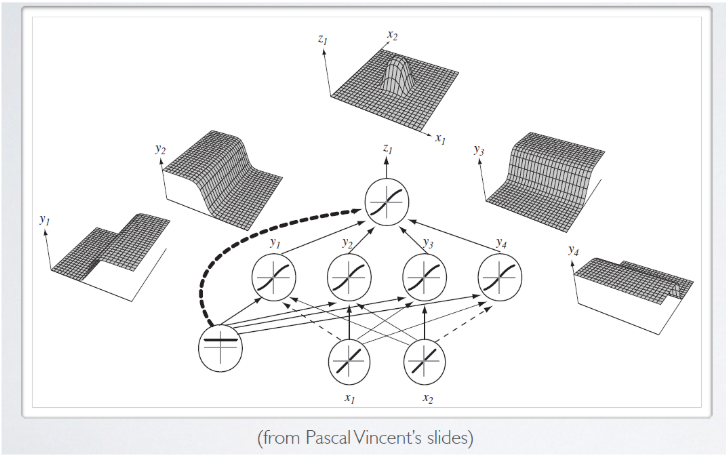

# How to get the gradients for weights of neurons 1 and 2?

__Chain rule__

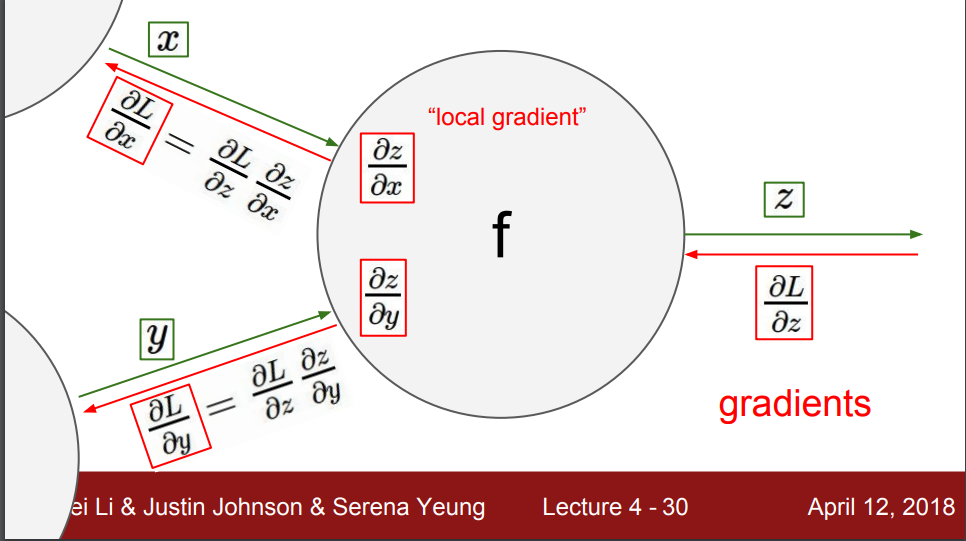

__What it means?__

$\frac{\partial{L}}{\partial{z}}$ is the error contribution due to $z$.

_Now, what is the distribution of that error on $x$ and $y$?_

The answer by chain is by weighting the upper error by the next gradients (=sensitivity) to each of x and y.

## Backprop
In the previous algorithm, we casually assumed that because a function is differentiable,
we can explicitly compute its derivative. In practice, a neural network function
consists of many tensor operations chained together, each of which has a simple,
known derivative. For instance, this is a network f composed of three tensor operations,
a, b, and c, with weight matrices W1, W2, and W3:

`f(W1, W2, W3) = a(W1, b(W2, c(W3)))`
Calculus tells us that such a chain of functions can be derived using the following identity,
called the chain rule: `f(g(x)) = f'(g(x)) * g'(x)`. Applying the chain rule to the
computation of the gradient values of a neural network gives rise to an algorithm called Backpropagation (also sometimes called reverse-mode differentiation). 

Backpropagation starts with the final loss value and works backward from the top layers to the bottom
layers, applying the chain rule to compute the contribution that each parameter
had in the loss value.
![image.png](attachment:image.png)

### Symbolic differentiation
Nowadays, and for years to come, people will implement networks in modern
frameworks that are capable of symbolic differentiation, such as TensorFlow. This means
that, given a chain of operations with a known derivative, they can compute a gradient
function for the chain (by applying the chain rule) that maps network parameter values
to gradient values. When you have access to such a function, the backward pass is
reduced to a call to this gradient function. Thanks to symbolic differentiation, you’ll
never have to implement the Backpropagation algorithm by hand. For this reason, we
won’t waste your time and your focus on deriving the exact formulation of the Backpropagation
algorithm in these pages. All you need is a good understanding of how
gradient-based optimization works.


# NN Anatomy (Revision of 1st example)
## 1. Data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## 2. Model

In [ ]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

In [ ]:
network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## 3. Loss
## 4. Optimizer
Both under one step in Keras called compile

In [ ]:
network.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [ ]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

ValueError: ignored

# Why the above error?
Let's have a look on the labels

In [ ]:
train_labels.shape

(60000,)

In [ ]:
train_labels[0]

5

Our final activation is 'softmax', and our loss is 'categorial'.

This means that, our output must be consistent with softmax output.

That format is called __One-Hot Encoding__

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
print(train_labels.shape)
print(train_labels[0])

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 4s 70us/step - loss: 0.2575 - accuracy: 0.9261
Epoch 2/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.1054 - accuracy: 0.9687
Epoch 3/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.0692 - accuracy: 0.9793
Epoch 4/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.0508 - accuracy: 0.9851
Epoch 5/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.0380 - accuracy: 0.9888


Another solution

60,000x5 is too much RAM!

Use sparse_categorical_crossentroppy loss

Expand only when needed --> batch

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.2578 - accuracy: 0.9246
Epoch 2/5
60000/60000 [==============================] - 4s 67us/step - loss: 0.1052 - accuracy: 0.9689
Epoch 3/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.0686 - accuracy: 0.9794
Epoch 4/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.0498 - accuracy: 0.9851
Epoch 5/5
60000/60000 [==============================] - 4s 68us/step - loss: 0.0382 - accuracy: 0.9888
